<center>  <h2> Predicting the Price of Land in Lagos, Nigeria </h2> </center>

<center><h3>By Ohis Lawrence</h3></center>

#### To begin, I imported the required modules 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import folium
import locale
%matplotlib inline

#### The data used was scrape of website and cleaned 

#### I imported the data and saved it as a dataframe

In [3]:
df = pd.read_csv('labs/DP0701EN/lagosdata.csv')

##### then we view part of the data

In [4]:
df.head()

,Unnamed: 0,Prices,cost per sqm,Address,point,latitude,longitude,TotalSQM
0,0,937500,2778,"IKORODU, IKORODU ROAD,LAGOS, NIGERIA","(6.6191233, 3.5041271, 0.0)",6.619123,3.504127,337.473002
1,1,5000000,8333,"AJAH,LAGOS, NIGERIA","(6.4694716, 3.5623861, 0.0)",6.469472,3.562386,600.024001
2,2,30000000,50000,"ABRAHAM ADESANYA , AJAH,LAGOS, NIGERIA","(6.4698542, 3.58513306042361, 0.0)",6.469854,3.585133,600.000000
3,3,6500000,21667,"LEKKI, LEKKI EXPRESSWAY, LEKKI,LAGOS, NIGERIA","(6.4123323, 4.0947395, 0.0)",6.412332,4.094739,299.995385
4,4,850000,1417,"EPE, AJAH,LAGOS, NIGERIA","(6.4642897, 3.5592279, 0.0)",6.464290,3.559228,599.858857


#### I checked the data to make sure columns are what they should be

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 8 columns):
Unnamed: 0      138 non-null int64
Prices          138 non-null int64
cost per sqm    138 non-null int64
Address         138 non-null object
point           138 non-null object
latitude        138 non-null float64
longitude       138 non-null float64
TotalSQM        138 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 8.8+ KB


In [5]:
df['Address'] =  df['Address'].str.upper()

With the help of groupby method we can find the average price per square meter per neighborhood

In [6]:
mean_by_neighborhood = df.groupby('Address').mean()[['cost per sqm']]
mean_by_neighborhood.columns = ['mean_sqm']

# Save a dictionary for later use
my_dict = mean_by_neighborhood.to_dict()

mean_by_neighborhood.reset_index(inplace=True)
# The 10 most expensive neighborhoods.
mean_by_neighborhood.sort_values(by='mean_sqm', ascending=False).head(10)

,Address,mean_sqm
15,"AHMADU BELLO WAY,, VICTORIA ISLAND,LAGOS, NIGERIA",900000.0
18,"AKIN ADESOLA, VICTORIA ISLAND,LAGOS, NIGERIA",639324.5
17,"AKIN ADESOLA STREET, VICTORIA ISLAND,LAGOS, NI...",578947.0
12,"ADMIRALTY ROAD, LEKKI PHASE 1, LEKKI,LAGOS, NI...",560000.0
49,"IKOYI CRESCENT , IKOYI,LAGOS, NIGERIA",546875.0
43,"GLOVER ROAD, IKOYI,LAGOS, NIGERIA",493287.0
67,"OFF 3RD AVENUE, BANANA ISLAND, IKOYI,LAGOS, NI...",489998.0
9,"ADEOLA ODEKU, VICTORIA ISLAND,LAGOS, NIGERIA",457856.5
20,"ALFRED REWANE ROAD, IKOYI,LAGOS, NIGERIA",450763.0
42,"GLOVER ROAD , IKOYI,LAGOS, NIGERIA",441176.0


In [10]:
df.rename(columns={'cost per sqm': 'costpersqm'}, inplace=True)

In [7]:
map_ba = folium.Map(location=[6.5244, 3.3792], zoom_start=12)

map_ba.choropleth(geo_data='nigeria_geojson.geojson', 
             key_on = 'feature.properties.Address', 
             data = mean_by_neighborhood, 
             columns = ['Address', 'mean_sqm'],
             fill_color = 'YlGn',
             fill_opacity = 0.7,
             line_opacity = 0.7,
             legend_name = 'Price per square meter in Naira'
            )

In [16]:
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

for latitude, longitude, TotalSQM, costpersqm in zip(df['latitude'], df['longitude'], df['TotalSQM'], df['costpersqm']):
    
    label = 'Area: {} m² | Price: {}'.format(str(TotalSQM)[:-2], locale.currency(costpersqm, grouping=True)[:-3])
    label = folium.Popup(label)
    
    folium.CircleMarker(
        [latitude, longitude],
        radius = 3,
        fill = True,
        fill_opacity = 0.5,
        popup = label,
        
    ).add_to(map_ba) 

In [17]:
map_ba

## 2. Linear regression

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error

plt.style.use('seaborn')

we make a couple of scatterplots to visualize how prices are related with the total area. It's easy to identify the outlier

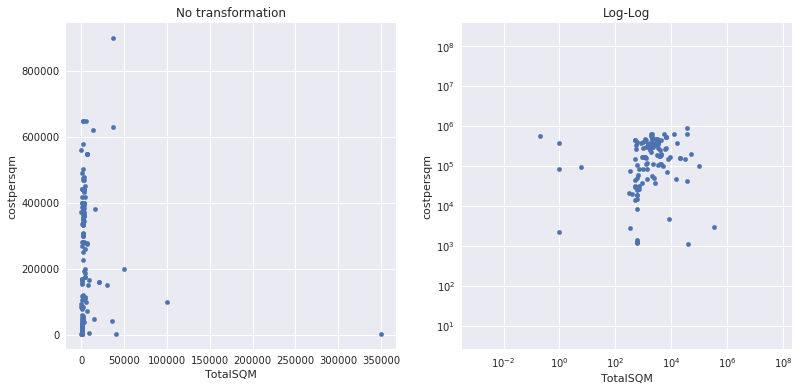

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,6))
df.plot(kind='scatter', x='TotalSQM', y='costpersqm', title='No transformation', ax=ax1)
df.plot(kind='scatter', x='TotalSQM', y='costpersqm', title='Log-Log',loglog=True, ax=ax2)

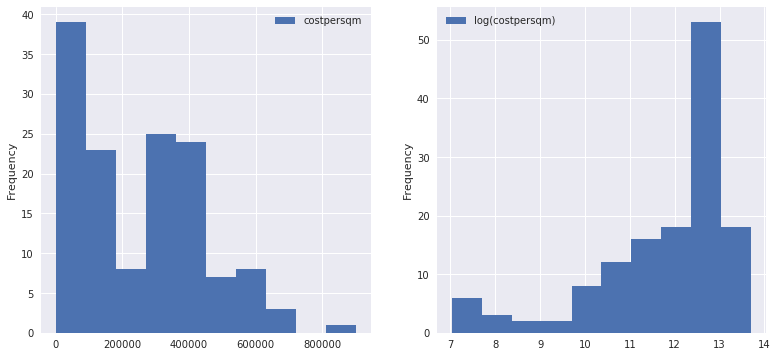

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,6))
df.plot(kind='hist', y='costpersqm', ax=ax1)
df['costpersqm'].apply(np.log).plot(kind='hist', ax=ax2, label='log(costpersqm)')
plt.legend()

Split the dataset and fit.

In [23]:
X = df[['TotalSQM']]
y = df[['costpersqm']]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

We will be using RMSLE because it penalizes an under-predicted estimate greater than an over-predicted estimate

In [26]:
y_pred = lr.predict(X_test)

'RMSLE: %.2f' % np.sqrt(mean_squared_log_error(y_test, y_pred))

'RMSLE: 1.88'

This time, we use a log-log space

In [27]:
lr.fit(X_train.apply(np.log), y_train.apply(np.log))
y_pred = lr.predict(X_test.apply(np.log))

'RMSLE: %.2f' % np.sqrt(mean_squared_log_error(y_test, np.exp(y_pred)))

'RMSLE: 1.79'

In [29]:
a,b = lr.coef_, lr.intercept_

Text(0, 0.5, 'cost per sqm')

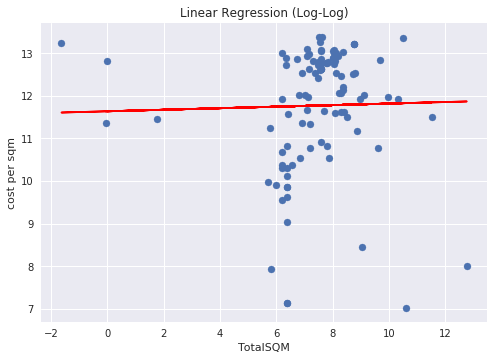

In [32]:
plt.scatter(X_train.apply(np.log), y_train.apply(np.log))
plt.plot(X_train.apply(np.log), X_train.apply(np.log)*a + b, c='red')
plt.title('Linear Regression (Log-Log)')
plt.xlabel('TotalSQM')
plt.ylabel('cost per sqm')

### Foursquare data

In [33]:
CLIENT_ID = 'XRXQM4H0XZE1CG2G1FPJRODWMSI4X4D1XSVQV4BCWXQPRCTI'
CLIENT_SECRET = '1SDTTENDUQ3ZXVUHLT2JCIL0PZ1Q1NPY1JKVOXJ2XOGBJ2H5'
VERSION = '20180604'
LIMIT = 1000
radius = 500

In [34]:
def venues_near(lat, long):

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        radius, 
        LIMIT)
    
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    
    return len(venues)

In [35]:
for i in range(df.shape[0]-1):
    df.loc[i, 'venues_near'] = venues_near(df['latitude'][i], df['longitude'][i])

In [36]:
df.head()

,Unnamed: 0,Prices,costpersqm,Address,point,latitude,longitude,TotalSQM,venues_near
0,0,937500,2778,"IKORODU, IKORODU ROAD,LAGOS, NIGERIA","(6.6191233, 3.5041271, 0.0)",6.619123,3.504127,337.473002,5.0
1,1,5000000,8333,"AJAH,LAGOS, NIGERIA","(6.4694716, 3.5623861, 0.0)",6.469472,3.562386,600.024001,5.0
2,2,30000000,50000,"ABRAHAM ADESANYA , AJAH,LAGOS, NIGERIA","(6.4698542, 3.58513306042361, 0.0)",6.469854,3.585133,600.000000,3.0
3,3,6500000,21667,"LEKKI, LEKKI EXPRESSWAY, LEKKI,LAGOS, NIGERIA","(6.4123323, 4.0947395, 0.0)",6.412332,4.094739,299.995385,0.0
4,4,850000,1417,"EPE, AJAH,LAGOS, NIGERIA","(6.4642897, 3.5592279, 0.0)",6.464290,3.559228,599.858857,4.0


Replace NaN's with 1

In [37]:
df[ df['venues_near'].isna()]

,Unnamed: 0,Prices,costpersqm,Address,point,latitude,longitude,TotalSQM,venues_near
137,137,3500000000,546875,"IKOYI CRESCENT , IKOYI,LAGOS, NIGERIA","(6.4615332, 3.4334628, 0.0)",6.461533,3.433463,6400.0,NaN


In [38]:
df['venues_near'].fillna(1, inplace=True)
df[ df['venues_near'].isna()]

,Unnamed: 0,Prices,costpersqm,Address,point,latitude,longitude,TotalSQM,venues_near


In [39]:
X = df[['TotalSQM', 'venues_near']]
y = df[['costpersqm']]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

'RMSLE: %.2f' % np.sqrt(mean_squared_log_error(y_test, y_pred))

'RMSLE: 1.85'